## 1. Datenimport und Initialisierung

In diesem Abschnitt werden die OpenJur-Urteilstexte aus dem Datenverzeichnis eingelesen und die technische Datenbasis für die nachfolgenden Verarbeitungsschritte geschaffen. Dazu werden die benötigten Bibliotheken importiert und die verfügbaren Textdateien identifiziert.


### 1.1 Import der benötigten Bibliotheken

Zu Beginn werden die für die weitere Verarbeitung erforderlichen Python-Bibliotheken importiert. Diese umfassen Funktionen für Dateizugriffe, reguläre Ausdrücke, Datenverarbeitung mit Pandas sowie den Export der Ergebnisse im JSON-Format.

In [2]:
#Import
import os
import re
import json
import pandas as pd

### 1.2 Einlesen der OpenJur-Urteilstexte 

In diesem Schritt werden alle identifizierten Urteilstexte aus dem Datenverzeichnis eingelesen. Jede Datei wird über den Dateinamen einer eindeutigen Fallkennung (`case_id`) zugeordnet. Die Texte bilden die Rohdatenbasis für die nachfolgenden Extraktions- und Filterprozesse. Der Datenpfad wird im Code parametriert (`DATA_DIR`), um eine reproduzierbare Ausführung zu gewährleisten.

In [3]:
# (.txt) Dateien einlesen
DATA_DIR = "../data/Gerichtsurteile_Openjur" 
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".txt")]

print("Pfad:", os.path.abspath(DATA_DIR))
print("Anzahl .txt:", len(files))
print("Erste 10 Dateien:", files[:10])


Pfad: c:\Users\Lena\Documents\GitHub\ds_law\backend\data\Gerichtsurteile_Openjur
Anzahl .txt: 2375
Erste 10 Dateien: ['2090187.txt', '2112111.txt', '2112115.txt', '2112117.txt', '2112118.txt', '2112119.txt', '2112121.txt', '2112123.txt', '2124977.txt', '2126821.txt']


---

## 2. Extraktion relevanter Urteilsbestandteile und Selektion der Landgerichtsurteile

In diesem Abschnitt werden die eingelesenen Urteilstexte weiterverarbeitet, um für die nachfolgende Analyse relevante Textbestandteile gezielt zu extrahieren. Hierzu zählen insbesondere ein begrenzter Kopfbereich zur Voranalyse sowie der Tenor als Kern der gerichtlichen Entscheidung. Die strukturierte Aufbereitung dieser Textsegmente bildet die Grundlage für Filter-, Klassifikations- und Extraktionsschritte in den folgenden Abschnitten.

### 2.1 Aufbau des DataFrames und Extraktion eines Kopfbereichs

Die eingelesenen Texte werden in einem DataFrame (`df`) gespeichert. Zusätzlich wird ein begrenzter Kopfbereich (`head`) aus den ersten Zeichen extrahiert, da strukturelle Metadaten wie Gerichtstyp, Entscheidungsart und Zitierzeilen typischerweise am Anfang des Dokuments auftreten. Dieser Kopfbereich dient als effizienter Suchraum für die spätere Identifikation von Landgerichtsurteilen.


In [4]:
rows = []
for fn in files:
    case_id = fn.replace(".txt", "")
    path = os.path.join(DATA_DIR, fn)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    rows.append({"case_id": case_id, "text": text})

df = pd.DataFrame(rows)
print("Gesamt eingelesen:", len(df))


Gesamt eingelesen: 2375


In [5]:
HEAD_CHARS = 8000
df["head"] = df["text"].astype(str).str.slice(0, HEAD_CHARS)

print("Head-Länge (Beispiel):", len(df.loc[0, "head"]))


Head-Länge (Beispiel): 8000


### 2.2 Extraktion des Tenors

Der Tenor enthält die eigentliche gerichtliche Entscheidung und ist daher für die inhaltliche Bewertung besonders relevant. Mithilfe regulärer Ausdrücke wird der Textabschnitt zwischen der Überschrift „Tenor“ und den nachfolgenden Abschnitten (z. B. „Tatbestand“ oder „Gründe“) extrahiert und in einer separaten Spalte gespeichert.

In [6]:
def extract_tenor(text: str) -> str:
    if not isinstance(text, str):
        return ""

    m_start = re.search(r"\bTenor\b", text, flags=re.IGNORECASE)
    if not m_start:
        return ""

    start = m_start.end()

    # Begrenztes Suchfenster nach dem Tenor (robuster gegen Navigation)
    window = text[start:start + 20000]

    m_end = re.search(
        r"\b(Tatbestand|Gründe|Gruende|Entscheidungsgründe|Entscheidungsgruende)\b",
        window,
        flags=re.IGNORECASE
    )

    end = start + m_end.start() if m_end else min(len(text), start + 8000)
    return text[start:end].strip()
df["tenor"] = df["text"].apply(extract_tenor)
print("Tenor vorhanden:", (df["tenor"].str.len() > 0).sum(), "von", len(df))


Tenor vorhanden: 2362 von 2375


### 2.3 Identifikation von Landgerichtsurteilen (LG)

Die Selektion der Landgerichtsurteile erfolgt anhand einer OpenJur-spezifischen Zitierzeile im Kopfbereich (Regex: „Einfach“ gefolgt von „LG“). Auf dieser Grundlage wird eine boolesche Variable erzeugt und der Teilkorpus df_lg gebildet.

In [7]:
# Wir suchen nach der Zeile, die mit "Einfach" beginnt, gefolgt von "LG"
# Der Regex r"Einfach\s*\n\s*LG" stellt sicher, dass LG direkt darunter steht
pattern_zitierung_lg = r"Einfach\s*\n\s*LG"

# Wir wenden das auf die Spalte an, die den Kopftext enthält
df["is_landgericht"] = df["head"].str.contains(pattern_zitierung_lg, regex=True, na=False)

# Jetzt erstellen wir den sauberen Dataframe
df_lg = df[df["is_landgericht"] == True].copy()

print("-" * 40)
print(f"✅ Echte LG-Urteile (über Zitierzeile): {len(df_lg)}")
print("-" * 40)

----------------------------------------
✅ Echte LG-Urteile (über Zitierzeile): 1189
----------------------------------------


### 2.4 Segmentierung der Urteile in juristische Abschnitte
Für die spätere Extraktion werden die Urteile in juristisch sinnvolle Teile zerlegt: Rubrum, Tenor, Tatbestand und Entscheidungsgründe. Dadurch kann das Modell gezielt relevante Passagen verarbeiten.
Die Segmentierung dient dazu, spätere Analysen gezielt auf entscheidungsrelevante Abschnitte (insb. Tenor und Entscheidungsgründe) zu fokussieren.


In [8]:
def split_judgment(text):
    """
    Teilt ein Urteil in Rubrum, Tenor, Tatbestand und Entscheidungsgründe auf.
    """
    segments = {
        "rubrum": "",
        "tenor": "",
        "tatbestand": "",
        "entscheidungsgruende": ""
    }
    
    # Muster für die Abschnittsüberschriften
    # Das Rubrum ist alles vor dem Tenor
    m_tenor = re.search(r"\bTenor\b", text, re.IGNORECASE)
    m_tatbestand = re.search(r"\bTatbestand\b", text, re.IGNORECASE)
    m_gruende = re.search(r"\b(Entscheidungsgründe|Entscheidungsgruende|Gründe|Gruende)\b", text, re.IGNORECASE)
    
    if m_tenor:
        segments["rubrum"] = text[:m_tenor.start()].strip()
        
        # Tenor bis Tatbestand
        if m_tatbestand:
            segments["tenor"] = text[m_tenor.end():m_tatbestand.start()].strip()
            
            # Tatbestand bis Gründe
            if m_gruende:
                segments["tatbestand"] = text[m_tatbestand.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tatbestand"] = text[m_tatbestand.end():].strip()
        else:
            # Falls kein Tatbestand gefunden wird, Tenor bis zum Ende oder Gründen
            if m_gruende:
                segments["tenor"] = text[m_tenor.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tenor"] = text[m_tenor.end():].strip()
                
    return segments

# Beispielanwendung auf den Dataframe
df_lg['segments'] = df_lg['text'].apply(split_judgment)

## 3 Prompt-Generierung und Pilotierung der LLM-Extraktion (Gemini Batch)
Um API- und Token-Limits zu berücksichtigen, werden OpenJur-spezifische Navigationselemente aus dem Rubrum entfernt und alle Abschnitte in ihrer Länge begrenzt. Auf Basis dieser vorverarbeiteten Textsegmente wird ein standardisierter Prompt generiert, der die Extraktion der abgestimmten Variablen im JSON-Format steuert.
Die segmentweise Längenbegrenzung dient der Einhaltung von Token-Limits sowie der Reduktion von Kosten und Laufzeit, ohne entscheidungsrelevante Passagen (insb. Tenor und Entscheidungsgründe) zu verlieren.


### 3.1 Aufbereitung der Segmente und Definition des Extraktions-Prompts

Der Prompt wurde so konzipiert, dass er neben technischen Features (Motor, Kilometer) gezielt die Anforderungen der Aufgabenstellung erfüllt. Kernaspekte sind die Identifikation des Gerichtstyps sowie die Differenzierung der Zielvariable in Schadensersatz, Klageabweisung und prozessuale Sonderfälle („Sonstige“). Durch explizite Anweisungen zum Ausschluss von Zinsen und zur Erkennung von Streitwertbeschlüssen wird eine hohe Datenqualität für das anschließende Machine Learning sichergestellt.

In [47]:
def clean_rubrum(rubrum: str) -> str:
    if not isinstance(rubrum, str):
        return ""

    blacklist = [
        "rechtsprechung", "aktuell", "trending", "filter",
        "über openjur", "spenden", "api", "hilfe",
        "startseite", "bundesland", "gerichtsbarkeit",
        "impressum", "datenschutz", "nutzungsbedingungen",
        "fachzeitschriften", "suchen", "changelog", "einfach",
        "json", "bibtex", "ris"
    ]

    lines = []
    for line in rubrum.splitlines():
        l = line.strip().lower()
        if not l:
            continue
        if any(b in l for b in blacklist):
            continue
        lines.append(line.strip())

    return "\n".join(lines[:5])   

def slim_segments(segments):
    return {
        "rubrum": clean_rubrum(segments.get("rubrum") or "")[:2500],
        "tenor": (segments.get("tenor") or "")[:4000],
        "tatbestand": (segments.get("tatbestand") or "")[:3500],
        "entscheidungsgruende": (segments.get("entscheidungsgruende") or "")[:7000],
    }
def get_gemini_prompt(segments):
    """
    Erstellt den finalen Prompt basierend auf den Urteilssegmenten.
    """
    s = slim_segments(segments)

    prompt = f"""
Analysiere die folgenden Abschnitte eines Gerichtsurteils zum Dieselskandal und extrahiere die Variablen präzise als JSON-Liste. 

### URTEILS-BESTANDTEILE:
RUBRUM (Kopfbereich mit Gericht & Datum): 
{s['rubrum']}

TENOR (Ergebnis): 
{s['tenor']}

TATBESTAND (Sachverhalt): 
{s['tatbestand']}

ENTSCHEIDUNGSGRÜNDE (Rechtliche Würdigung): 
{s['entscheidungsgruende']}

### EXTRAKTIONS-AUFGABE:
Extrahiere folgende Variablen (bei Nichtfinden 'null' angeben):

WICHTIG (Validierung & Datenqualität):
1) **Gerichtstyp** muss explizit angegeben werden (z.B. "Landgericht", "Oberlandesgericht", "Amtsgericht").  
2) **Sonstige-Kategorie (prozessuale Dokumente):** Falls das Dokument **keine materielle Entscheidung über einen Schadensersatzanspruch** enthält (z.B. nur Streitwertfestsetzung/-beschluss, Prozesskostenhilfe/PKH, Kostenentscheidung ohne Sachentscheidung, Ablehnungsgesuch/Befangenheit, rein prozessualer Beschluss), dann setze zwingend:
   - LABEL_Anspruch_Schadensersatz = false
   - LABEL_Schadensersatzhoehe_Betrag = null
   - LABEL_Schadensersatzhoehe_Range = "Sonstige"
3) **Betrag ohne Zinsen:** LABEL_Schadensersatzhoehe_Betrag ist **ohne Zinsen/Verzugszinsen/Nebenforderungen** anzugeben.

1. **Input-Variablen (Features):**
   - Dieselmotor_Typ: (Beispiel: "EA 189", "EA 288")
   - Art_Abschalteinrichtung: (Beispiel: "Umschaltlogik", "Thermofenster")
   - KBA_Rueckruf: (Boolean: true/false - Beispiel: true)
   - Fahrzeugstatus: ("Neuwagen" oder "Gebrauchtwagen")
   - Fahrzeugmodell_Baureihe: (Beispiel: "VW Golf 2.0 TDI")
   - Update_Status: (Boolean: true/false/null - Beispiel: false)
   - Kilometerstand_Kauf: (Integer - Beispiel: 15200)
   - Kilometerstand_Klageerhebung: (Integer - Beispiel: 45000)
   - Erwartete_Gesamtlaufleistung: (Integer - Beispiel: 250000)
   - Kaufdatum: (Date YYYY-MM-DD - Beispiel: 2014-05-12)
   - Uebergabedatum: (Date YYYY-MM-DD - Beispiel: 2014-05-20)
   - Datum_Klageerhebung: (Date YYYY-MM-DD - Beispiel: 2018-11-03)
   - Beklagten_Typ: ("Händler" oder "Hersteller")
   - Datum_Urteil: (Date YYYY-MM-DD - Beispiel: 2019-12-17)
   - Kaufpreis: (Float in EUR - Beispiel: 25900.00)
   - Nacherfuellungsverlangen_Fristsetzung: ("Ja", "Nein", "Entbehrlich")
   - Klageziel: ("Rückabwicklung", "Minderung", "Schadensersatz")
   - Rechtsgrundlage: (Beispiel: "§ 826 BGB", "§ 437 BGB")

2. **Zielvariablen (Labels):**
   - LABEL_Anspruch_Schadensersatz (Boolean: true/false - Beispiel: true)
   - LABEL_Schadensersatzhoehe_Betrag (Float in EUR - Beispiel: 18450.50)
   - LABEL_Schadensersatzhoehe_Range (Beispiel: "< 5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", "> 25000", "Abgewiesen")

### AUSGABEFORMAT:
Antworte NUR mit einem validen JSON-Objekt in einer Liste:
[{{
  "case_id": null,
  "Gerichtstyp": null,
  "Dieselmotor_Typ": null,
  "Art_Abschalteinrichtung": null,
  "KBA_Rueckruf": null,
  "Fahrzeugstatus": null,
  "Fahrzeugmodell_Baureihe": null,
  "Update_Status": null,
  "Kilometerstand_Kauf": null,
  "Kilometerstand_Klageerhebung": null,
  "Erwartete_Gesamtlaufleistung": null,
  "Kaufdatum": null,
  "Uebergabedatum": null,
  "Datum_Klageerhebung": null,
  "Nachweis_Aufklaerung": null,
  "Beklagten_Typ": null,
  "Datum_Urteil": null,
  "Kaufpreis": null,
  "Nacherfuellungsverlangen_Fristsetzung": null,
  "Klageziel": null,
  "Rechtsgrundlage": null,
  "LABEL_Anspruch_Schadensersatz": null,
  "LABEL_Schadensersatzhoehe_Betrag": null,
  "LABEL_Schadensersatzhoehe_Range": null
}}]
""".strip()

    return prompt


In [ ]:
'''import time
import pandas as pd
import json
import re
import os
from google import genai

# --- 1. EINSTELLUNGEN ---
MODEL_NAME = "models/gemini-2.5-flash"
CHECKPOINT_FILE = "gemini_results_checkpoint.csv" # Sicherungsdatei

# API Key Client starten
api_key = os.getenv("GEMINI_API_KEY") 
client = genai.Client(api_key=api_key)

# --- 2. HILFSFUNKTIONEN ---
def extract_json_from_llm(text: str):
    text = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)
    m = re.search(r"(\[\s*\{.*?\}\s*\]|\{.*?\})", text, flags=re.DOTALL)
    if not m: raise ValueError("Kein JSON gefunden")
    return json.loads(m.group(1))

# --- 3. DER HAUPT-LAUF (ROBUST & KORREKTER ZÄHLER) ---
working_df = df_lg.copy() 
results = []
errors = []

print(f"🚀 Starte 'Pay-as-you-go' Lauf für {len(working_df)} Fälle mit {MODEL_NAME}...")
print(f"💾 Zwischenergebnisse werden alle 50 Fälle in '{CHECKPOINT_FILE}' gespeichert.")

start_time = time.time()

# KORREKTUR: Wir nutzen enumerate(), um einen echten Zähler (i) zu haben
for i, (index, row) in enumerate(working_df.iterrows()):
    case_id = row['case_id']
    
    # Retry-Logik
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # 1. Prompt holen (MIT Sicherheits-Check für Strings)
            segs = row["segments"]
            if isinstance(segs, str):
                import ast
                segs = ast.literal_eval(segs)
            
            # (Hier war dein Einrückungsfehler)
            prompt = get_gemini_prompt(segs)
            
            # 2. Anfrage senden (Das fehlte in deinem Code!)
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt
            )
            
            # 3. Ergebnis verarbeiten
            data = extract_json_from_llm(response.text)
            if isinstance(data, list): data = data[0]
            
            data["case_id"] = case_id
            results.append(data)
            
            # Fortschrittsanzeige & Checkpoint (nutzt jetzt 'i' statt 'index')
            if (i + 1) % 50 == 0:
                elapsed = time.time() - start_time
                
                # Checkpoint speichern
                pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)
                
                print(f"✅ {i + 1}/{len(working_df)} geschafft ({elapsed:.1f}s) -> 💾 Checkpoint gesichert.")
            
            break # Erfolg -> Raus aus Retry

        except Exception as e:
            error_msg = str(e)
            # Exponentielles Warten: 5s, 10s, 15s
            wait_time = 5 * (attempt + 1)
            
            if "429" in error_msg or "RESOURCE_EXHAUSTED" in error_msg:
                if attempt < max_retries - 1:
                    print(f"⏳ Limit bei {case_id}. Warte {wait_time}s (Versuch {attempt+1}/{max_retries})...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"❌ Limit-Fehler bei {case_id} endgültig.")
                    errors.append({"case_id": case_id, "error": "429 Limit"})
            else:
                print(f"⚠️ Fehler bei {case_id}: {error_msg}")
                errors.append({"case_id": case_id, "error": error_msg})
                break

print("\n🎉 FERTIG!")
print(f"Erfolgreich extrahiert: {len(results)}")

# --- 4. FINALES SPEICHERN ---
df_final = pd.DataFrame(results)
filename = "gemini_results_paid_complete.csv"
df_final.to_csv(filename, index=False)
print(f"✅ Finale Daten gespeichert als: {filename}")

# Aufräumen: Wenn alles geklappt hat, löschen wir den Checkpoint
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("🧹 Checkpoint-Datei entfernt (Job erledigt).")'''

🚀 Starte 'Pay-as-you-go' Lauf für 1189 Fälle mit models/gemini-2.5-flash...
💾 Zwischenergebnisse werden alle 50 Fälle in 'gemini_results_checkpoint.csv' gespeichert.
✅ 50/1189 geschafft (976.1s) -> 💾 Checkpoint gesichert.
✅ 100/1189 geschafft (1830.6s) -> 💾 Checkpoint gesichert.
✅ 150/1189 geschafft (2801.6s) -> 💾 Checkpoint gesichert.
✅ 200/1189 geschafft (3741.5s) -> 💾 Checkpoint gesichert.
✅ 250/1189 geschafft (4609.3s) -> 💾 Checkpoint gesichert.
✅ 300/1189 geschafft (5551.5s) -> 💾 Checkpoint gesichert.
✅ 350/1189 geschafft (6510.9s) -> 💾 Checkpoint gesichert.
✅ 400/1189 geschafft (7372.8s) -> 💾 Checkpoint gesichert.
✅ 450/1189 geschafft (8183.8s) -> 💾 Checkpoint gesichert.
✅ 500/1189 geschafft (8984.6s) -> 💾 Checkpoint gesichert.
✅ 550/1189 geschafft (9833.6s) -> 💾 Checkpoint gesichert.
✅ 600/1189 geschafft (10653.7s) -> 💾 Checkpoint gesichert.
✅ 650/1189 geschafft (11524.9s) -> 💾 Checkpoint gesichert.
✅ 700/1189 geschafft (12349.7s) -> 💾 Checkpoint gesichert.
✅ 750/1189 geschafft 

## 4 Verarbeitung der Modellantworten und Erstellung des Extraktions-Datensatzes

In diesem Abschnitt werden die Ergebnisse des direkten API-Durchlaufs (`gemini_results_paid_complete.csv`) eingelesen und mit den ursprünglichen Urteilstexten verknüpft. Um eine hohe Datenqualität für das anschließende Machine Learning zu gewährleisten, erfolgen hier zudem wichtige Bereinigungsschritte:

1.  **Daten-Merge:** Die KI-Extraktionen werden über die eindeutige `case_id` mit den Originaltexten (`df_lg`) zusammengeführt. Dabei wird sichergestellt, dass die ID in beiden Datensätzen als String behandelt wird, um Datenverlust zu vermeiden.
2.  **Bereinigung von Geldbeträgen:** Die Funktion `clean_money_robust` konvertiert diverse deutsche Währungsformate (z. B. "25.000,00 €", "1.000 Euro" oder "25.000") zuverlässig in numerische Gleitkommazahlen (`float`), indem sie Tausenderpunkte und Währungssymbole korrekt interpretiert und entfernt.
3.  **Standardisierung der Zielvariable:** Die Funktion `determine_target_label` vereinheitlicht die unterschiedlichen Rückgabeformate des Modells (z. B. "True", "yes", "1") in saubere Kategorien ("Schadensersatz", "Abgewiesen", "Sonstige").

Abschließend wird der bereinigte Gesamtdatensatz sowohl im CSV-Format (für manuelle Prüfung) als auch im Parquet-Format (für performante Weiterverarbeitung) gespeichert.

In [9]:
df_lg

,case_id,text,head,tenor,is_landgericht,segments
0,2090187,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,I. Die Klage wird abgewiesen.II. Der Kläger ha...,True,{'rubrum': 'Rechtsprechung Aktuell ...
1,2112111,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"1. Die Beklagte wird verurteilt, an die klagen...",True,{'rubrum': 'Rechtsprechung Aktuell ...
2,2112115,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"Der Beklagte zu 1) wird verurteilt, an die Klä...",True,{'rubrum': 'Rechtsprechung Aktuell ...
3,2112117,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"Die Beklagte wird verurteilt, an den Kläger 27...",True,{'rubrum': 'Rechtsprechung Aktuell ...
4,2112118,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"Die Beklagte wird verurteilt, an die Klägerin ...",True,{'rubrum': 'Rechtsprechung Aktuell ...
...,...,...,...,...,...,...
2368,969747,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"Die Beklagte wird verurteilt, an die Klägerin ...",True,{'rubrum': 'Rechtsprechung Aktuell ...
2369,970086,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"Die Beklagte wird verurteilt, den Kläger von d...",True,{'rubrum': 'Rechtsprechung Aktuell ...
2371,972762,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,1. Die Klage wird abgewiesen.2. Die Klägerin h...,True,{'rubrum': 'Rechtsprechung Aktuell ...
2372,972813,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,Rechtsprechung\n\t\t\t\t\t\tAktuell\n\t\t\t\t\...,"1. Die Beklagte wird verurteilt, dem Kläger ei...",True,{'rubrum': 'Rechtsprechung Aktuell ...


### 4.1 Mergen der Daten

In [10]:
# Wir laden die Ergebnisse, bereinigen Datentypen und führen sie mit den Originaltexten zusammen.
%pip install pyarrow 
import pandas as pd
import numpy as np
import os
import re

# 1. Konfiguration & Laden
RESULTS_FILENAME = "gemini_results_paid_complete.csv"

if not os.path.exists(RESULTS_FILENAME):
    raise FileNotFoundError(f"Datei {RESULTS_FILENAME} fehlt! Bitte Kapitel 3 ausführen.")

print(f"📥 Lade Ergebnisse aus: {RESULTS_FILENAME}")
df_extracted = pd.read_csv(RESULTS_FILENAME)

# IDs für Merge sicherstellen (String)
df_lg["case_id"] = df_lg["case_id"].astype(str)
df_extracted["case_id"] = df_extracted["case_id"].astype(str)

# 2. Merge: Originaltexte (df_lg) + KI-Daten (df_extracted)
df_dataset = pd.merge(df_lg, df_extracted, on="case_id", how="inner")

print(f"✅ Merge erfolgreich: {len(df_dataset)} Datensätze.")

# --- BEREINIGUNGS-FUNKTIONEN ---

def clean_money_robust(val):
    """ Wandelt Strings wie '25.000,00' oder '1000 €' sicher in Floats um. """
    if pd.isna(val) or str(val).strip().lower() in ["null", "none", "nan", ""]:
        return 0.0
    
    if isinstance(val, (int, float)):
        return float(val)

    s = str(val).strip()
    # Entferne alles außer Ziffern, Punkt, Komma, Minus
    s = re.sub(r'[^\d.,-]', '', s)
    
    # Logik für deutsche Tausenderpunkte (z.B. 25.000 -> 25000)
    if "," in s:
        s = s.replace(".", "")  # Tausender weg
        s = s.replace(",", ".") # Dezimal-Komma zu Punkt
    else:
        # Fall "25.000" (ohne Komma) -> Punkt ist Tausender
        if "." in s:
            parts = s.split(".")
            # Wenn nach dem letzten Punkt genau 3 Ziffern kommen und davor auch was steht
            if len(parts) > 1 and len(parts[-1]) == 3:
                s = s.replace(".", "")
    
    try:
        return float(s)
    except ValueError:
        return 0.0

def determine_target_label(row):
    """ Bestimmt die Zielklasse: Schadensersatz, Abgewiesen oder Sonstige. """
    # 1. Sonstige (Prozessual)
    if str(row.get("LABEL_Schadensersatzhoehe_Range")).lower() == "sonstige":
        return "Sonstige"
    
    # 2. Anspruch (True/False prüfen)
    val = str(row.get("LABEL_Anspruch_Schadensersatz")).strip().lower()
    if val in ["true", "1", "1.0", "ja", "yes"]:
        return "Schadensersatz"
    
    return "Abgewiesen"

# --- ANWENDUNG ---

# Geld bereinigen
if "Kaufpreis" in df_dataset.columns:
    df_dataset["Kaufpreis_num"] = df_dataset["Kaufpreis"].apply(clean_money_robust)

if "LABEL_Schadensersatzhoehe_Betrag" in df_dataset.columns:
    df_dataset["Schadensersatz_Betrag_num"] = df_dataset["LABEL_Schadensersatzhoehe_Betrag"].apply(clean_money_robust)

# Label erstellen
df_dataset["target_label"] = df_dataset.apply(determine_target_label, axis=1)

# "Sonstige" rausschmeißen, da 7,2 % (86) vom Datensatz --> Rauschen
df_dataset = df_dataset[df_dataset["target_label"] != "Sonstige"].copy()

# Speichern
df_dataset.to_parquet("lg_diesel_urteile_final.parquet", index=False)
df_dataset.to_csv("lg_diesel_urteile_final.csv", index=False)

print("-" * 30)
print("📊 Verteilung Target-Label:")
print(df_dataset["target_label"].value_counts(dropna=False))
print(f"\n💾 Datensatz gespeichert (Parquet & CSV).")

Note: you may need to restart the kernel to use updated packages.
📥 Lade Ergebnisse aus: gemini_results_paid_complete.csv
✅ Merge erfolgreich: 1189 Datensätze.



[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


------------------------------
📊 Verteilung Target-Label:
target_label
Abgewiesen        572
Schadensersatz    531
Name: count, dtype: int64

💾 Datensatz gespeichert (Parquet & CSV).


In [12]:
df_dataset['LABEL_Schadensersatzhoehe_Range'].value_counts()

LABEL_Schadensersatzhoehe_Range
Abgewiesen     576
> 25000        176
15000-20000     91
10000-15000     84
20000-25000     70
5000-10000      60
< 5000          26
Name: count, dtype: int64

### 4.2 Vorbereitung des ML-Datensatzes

In [13]:
df_ml = df_dataset.copy()

# 1. Tatbestand extrahieren (hast du schon in 'tatbestand' umbenannt)
df_ml['tatbestand'] = df_ml['segments'].apply(lambda x: x.get('tatbestand', '') if isinstance(x, dict) else '')

# 2. Alle relevanten Input-Variablen definieren
# Hier fügen wir alles hinzu, was Gemini extrahiert hat
input_features = [
    'Dieselmotor_Typ', 'Fahrzeugstatus', 'Beklagten_Typ', 
    'Kaufpreis_num', 'Kilometerstand_Kauf', 'Erwartete_Gesamtlaufleistung',
    'Klageziel', 'Rechtsgrundlage'
]

# Labels (Y)
labels = ['LABEL_Anspruch_Schadensersatz', 'LABEL_Schadensersatzhoehe_Range']

# 3. Filtern und Cleaning
df_ml = df_ml.dropna(subset=['LABEL_Anspruch_Schadensersatz', 'tatbestand'])
df_ml['LABEL_Anspruch_Schadensersatz'] = df_ml['LABEL_Anspruch_Schadensersatz'].astype(int)

# Datensatz auf diese Auswahl kürzen
df_ml = df_ml[['case_id', 'tatbestand'] + input_features + labels]

# Split wie gehabt
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_ml, test_size=0.2, random_state=42, stratify=df_ml['LABEL_Anspruch_Schadensersatz']
)

In [14]:
train_df

,case_id,tatbestand,Dieselmotor_Typ,Fahrzeugstatus,Beklagten_Typ,Kaufpreis_num,Kilometerstand_Kauf,Erwartete_Gesamtlaufleistung,Klageziel,Rechtsgrundlage,LABEL_Anspruch_Schadensersatz,LABEL_Schadensersatzhoehe_Range
307,2206209,Der Kläger begehrt von der Beklagten im Zusamm...,EA 189,Neuwagen,Hersteller,34979.19,NaN,NaN,NaN,§ 439 BGB,0,Abgewiesen
929,2427245,Die Parteien streiten um Ansprüche des Klägers...,NaN,Gebrauchtwagen,Hersteller,49000.00,13600.0,NaN,Rückabwicklung,§ 826 BGB,1,> 25000
161,2178303,Der Kläger begehrt von der Beklagten Schadense...,OM 651,Gebrauchtwagen,Hersteller,50000.00,16500.0,NaN,Rückabwicklung,"§ 826 BGB, § 831 BGB",1,> 25000
968,2448428,Der Kläger begehrt Schadenersatz für das im Ra...,EA 189,Neuwagen,Hersteller,44565.74,NaN,NaN,Schadensersatz,"§§ 826, 31, 249 BGB",1,> 25000
656,2339195,Die Parteien streiten über Schadensersatzanspr...,EA 189,Gebrauchtwagen,Hersteller,13990.00,35884.0,NaN,Rückabwicklung,§ 826 BGB,1,10000-15000
...,...,...,...,...,...,...,...,...,...,...,...,...
772,2373774,Der Kläger erhebt Ansprüche auf Schadensersatz...,OM 607,Gebrauchtwagen,Hersteller,23500.00,12700.0,500000.0,Rückabwicklung,"§§ 826, 823 Abs. 2, 31 BGB i.V.m. § 263 StGB, ...",0,Abgewiesen
364,2262420,Der Kläger macht Ansprüche aus der sogenannten...,EA 189,Gebrauchtwagen,Händler,14895.00,69650.0,NaN,Rückabwicklung,"§§ 434, 437 BGB",0,Abgewiesen
127,2157967,Die Klägerin macht Ansprüche in Zusammenhang m...,NaN,Gebrauchtwagen,Hersteller,21500.00,NaN,NaN,Rückabwicklung,"§§ 823, 826 BGB",0,Abgewiesen
77,2149532,Die Parteien streiten um Ansprüche nach einem ...,EA 189,Gebrauchtwagen,Händler,17900.00,19990.0,NaN,Rückabwicklung,§ 437 BGB,1,10000-15000


In [15]:
test_df

,case_id,tatbestand,Dieselmotor_Typ,Fahrzeugstatus,Beklagten_Typ,Kaufpreis_num,Kilometerstand_Kauf,Erwartete_Gesamtlaufleistung,Klageziel,Rechtsgrundlage,LABEL_Anspruch_Schadensersatz,LABEL_Schadensersatzhoehe_Range
1160,2494282,Die Parteien streiten über Schadensersatzanspr...,EA 288,Neuwagen,Hersteller,28135.8,3.0,350000.0,Rückabwicklung,§ 826 BGB,0,Abgewiesen
231,2198290,Die klägerische Partei begehrt von der beklagt...,EA 189,NaN,Händler,20500.0,NaN,NaN,Minderung,"§§ 346 Abs. 1, 437 Nr. 2, 441 BGB",1,5000-10000
356,2260412,Der Kläger verlangt von der Beklagten zu 1. al...,EA 189,Gebrauchtwagen,Händler,32980.0,7200.0,400000.0,Rückabwicklung,"§§ 346, 348, 437 Abs. 2, 323, 434 BGB",1,> 25000
434,2294965,"Die Klagepartei nimmt die Beklagte, mit der am...",EA 189,Gebrauchtwagen,Hersteller,16990.0,23277.0,NaN,Schadensersatz,§ 826 BGB i.V.m. § 31 BGB,1,10000-15000
1059,2458018,Der Kläger nimmt die Beklagte auf Schadensersa...,XX 000 XXX xxx / XX 000 XXX 0 XxX,Gebrauchtwagen,Hersteller,59700.0,10950.0,NaN,Rückabwicklung,§ 826 BGB,1,> 25000
...,...,...,...,...,...,...,...,...,...,...,...,...
977,2448723,Der Kläger begehrt von den Beklagten Schadense...,NaN,Neuwagen,Hersteller,59000.0,NaN,NaN,Rückabwicklung,§ 826 BGB,1,> 25000
517,2307142,Die Klägerin klagt aus abgetretenem Recht. Hin...,EA 189,NaN,Hersteller,0.0,NaN,NaN,Rückabwicklung,§ 826 BGB,0,Abgewiesen
661,2339670,Die Parteien streiten um Ansprüche im Zusammen...,"1,6 Liter TDI",Gebrauchtwagen,Hersteller,3420.0,150000.0,NaN,Rückabwicklung,§ 826 BGB,1,< 5000
66,2148052,Die Klägerin begehrt aus abgetretenem Recht im...,EA 189,Neuwagen,Hersteller,35500.0,NaN,NaN,Schadensersatz,"§ 826 BGB, § 831 BGB",1,5000-10000


In [16]:
# %% [markdown]
# ### 4.2.1 Validierung der Klassenverteilung (Stratification Check)
# Wir prüfen, ob das Verhältnis von 'Sieg' (1) zu 'Niederlage' (0) in beiden Sets gleich ist. (kann auch wieder gelöscht werden)

def check_stratification(df_train, df_test, label_col):
    # Absolute Zahlen
    train_counts = df_train[label_col].value_counts()
    test_counts = df_test[label_col].value_counts()
    
    # Prozentuale Verteilung
    train_pct = df_train[label_col].value_counts(normalize=True) * 100
    test_pct = df_test[label_col].value_counts(normalize=True) * 100
    
    # Schöne Ausgabe
    stats = pd.DataFrame({
        'Train Count': train_counts,
        'Train %': train_pct,
        'Test Count': test_counts,
        'Test %': test_pct
    })
    
    print(f"📊 Verteilung für Label: {label_col}")
    print("-" * 50)
    print(stats.round(2))
    print("-" * 50)
    
    # Differenz-Check
    diff = abs(train_pct - test_pct).max()
    if diff < 1.0:
        print(f"✅ Exzellente Stratifizierung! (Abweichung < 1%)")
    else:
        print(f"⚠️ Warnung: Abweichung von {diff:.2f}% festgestellt.")

# Aufruf für unser Haupt-Label
check_stratification(train_df, test_df, 'LABEL_Anspruch_Schadensersatz')

📊 Verteilung für Label: LABEL_Anspruch_Schadensersatz
--------------------------------------------------
                               Train Count  Train %  Test Count  Test %
LABEL_Anspruch_Schadensersatz                                          
0                                      455     51.7         114   51.82
1                                      425     48.3         106   48.18
--------------------------------------------------
✅ Exzellente Stratifizierung! (Abweichung < 1%)


## 5. Datenaufbereitung für maschinelles Lernen

In diesem Abschnitt werden die Urteilstexte für die nachgelagerte prädiktive Modellierung aufbereitet. Hierzu erfolgt zunächst eine juristisch angepasste Textvorverarbeitung und die Ableitung numerischer Textrepräsentationen. Die für die supervised Lernphase erforderlichen Zielvariablen werden im Rahmen der LLM-basierten Extraktion (Abschnitt 4) erzeugt und anschließend mit den Textmerkmalen zusammengeführt (Abschnitt 5.4).
Ziel der Datenaufbereitung ist es, die extrahierten Merkmale in eine konsistente, auswertbare Form zu überführen, fehlende oder uneinheitliche Angaben zu behandeln und die Zielvariablen für die spätere Analyse eindeutig zu definieren.

### 5.1 Juristische Textvorverarbeitung

In [17]:
# %% [markdown]
# ### 5.1 Juristische Textvorverarbeitung
# Wir nutzen den in 4.4 extrahierten Tatbestand und führen die NLP-Reinigung durch.

# %%
import pandas as pd
import re
import spacy
from tqdm import tqdm

# 1. Spacy laden
try:
    nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])
except Exception:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "de_core_news_lg"])
    nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])

# 2. Die Reinigungs-Funktion (unverändert, da sie super arbeitet)
def legal_preprocess(text):
    if not isinstance(text, str) or not text or len(text) < 5: 
        return ""
    
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    
    # Platzhalter für Beträge, Paragraphen und Jahre
    money_regex = r'\d{1,3}(?:\.\d{3})*(?:,\d+)?\s*(?:eur|€|euro)'
    text = re.sub(money_regex, ' PLATZHALTER_BETRAG ', text)
    
    paragraph_regex = r'§+\s*\d+[a-z]?'
    text = re.sub(paragraph_regex, ' PLATZHALTER_PARAGRAPH ', text)
    
    text = re.sub(r'\b(19|20)\d{2}\b', ' PLATZHALTER_JAHR ', text)
    
    doc = nlp(text)
    tokens = [
        t.lemma_ for t in doc 
        if not t.is_stop and not t.is_punct and not t.is_space and len(t.text) > 1
    ]
    return " ".join(tokens)

# 3. Anwendung: Wir gehen DIREKT auf die Spalte 'tatbestand'
tqdm.pandas()

print("⚙️ Verarbeite TRAININGS-Daten (Tatbestand)...")
# Wir nutzen direkt 'tatbestand', das wir in 4.4 erstellt haben
train_df["cleaned_text"] = train_df["tatbestand"].progress_apply(legal_preprocess)

print("⚙️ Verarbeite TEST-Daten (Tatbestand)...")
test_df["cleaned_text"] = test_df["tatbestand"].progress_apply(legal_preprocess)

# 4. Quality Check: Leere Texte nach dem Preprocessing entfernen
# (Falls ein Tatbestand nur aus Stoppwörtern bestand)
train_df = train_df[train_df["cleaned_text"].str.len() > 0]
test_df = test_df[test_df["cleaned_text"].str.len() > 0]

print("-" * 30)
print(f"✅ Preprocessing abgeschlossen. Train: {len(train_df)}, Test: {len(test_df)}")

# Beispiel anzeigen
if not train_df.empty:
    print("\nBeispiel der bereinigten Tokens:")
    print(train_df["cleaned_text"].iloc[0][:300] + "...")

⚙️ Verarbeite TRAININGS-Daten (Tatbestand)...


100%|██████████| 880/880 [00:43<00:00, 20.14it/s]


⚙️ Verarbeite TEST-Daten (Tatbestand)...


100%|██████████| 220/220 [00:11<00:00, 18.79it/s]

------------------------------
✅ Preprocessing abgeschlossen. Train: 872, Test: 220

Beispiel der bereinigten Tokens:
Kläger begehren beklagter Zusammenhang sog. abgas-skandal Lieferung Neufahrzeug Zug zug Rückgabe beklagt gekauft autos.der Kläger erwerben 24.01. PLATZHALTER_JAHR beklagen handeln rabattiert Kaufpreis PLATZHALTER_BETRAG Mai PLATZHALTER_JAHR erstzugelassen anschließend übergeben wurde.d Abschluss kau...


In [18]:
# %% [markdown]
# ### 5.2 Word2Vec Training

# %%
from gensim.models import Word2Vec

# Wir trainieren NUR auf den Trainings-Tokens
train_tokens = [str(doc).split() for doc in train_df['cleaned_text']]

print("🚀 Trainiere Word2Vec (Skip-Gram)...")
w2v_model = Word2Vec(
    sentences=train_tokens, 
    vector_size=100, 
    window=5, 
    min_count=2, 
    workers=4, 
    sg=1, 
    seed=42
)

print(f"✅ Word2Vec bereit. Vokabular: {len(w2v_model.wv)} Wörter.")

🚀 Trainiere Word2Vec (Skip-Gram)...
✅ Word2Vec bereit. Vokabular: 11763 Wörter.


In [19]:
# %% [markdown]
# ### 5.3 Dokument-Vektorisierung

# %%
def get_doc_vector(doc, model):
    words = [w for w in str(doc).split() if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X_train_text = np.array([get_doc_vector(t, w2v_model) for t in train_df['cleaned_text']])
X_test_text = np.array([get_doc_vector(t, w2v_model) for t in test_df['cleaned_text']])

print(f"✅ Vektorisierung abgeschlossen. Train-Shape: {X_train_text.shape}")

✅ Vektorisierung abgeschlossen. Train-Shape: (872, 100)


In [20]:
# %% [markdown]
# ### 5.4 Finale Feature-Matrix (Struktur + Text)

# %%
def prepare_features(df, text_vectors):
    # 1. Text-Vektoren in DF wandeln
    emb_cols = [f"emb_{i}" for i in range(100)]
    df_emb = pd.DataFrame(text_vectors, columns=emb_cols, index=df.index)
    
    # 2. Strukturierte Gemini-Features wählen
    # Wir nehmen die Spalten, die du in 4.4 behalten hast
    cat_cols = ['Dieselmotor_Typ', 'Fahrzeugstatus', 'Beklagten_Typ', 'Klageziel', 'Rechtsgrundlage']
    num_cols = ['Kaufpreis_num', 'Kilometerstand_Kauf', 'Erwartete_Gesamtlaufleistung']
    
    # Nur Spalten nehmen, die auch wirklich im DF existieren (Sicherheits-Check)
    available_cat = [c for c in cat_cols if c in df.columns]
    available_num = [c for c in num_cols if c in df.columns]
    
    # 3. One-Hot-Encoding
    df_struct = pd.get_dummies(df[available_cat + available_num], columns=available_cat, dummy_na=True)
    
    # 4. Concat
    return pd.concat([df_struct.fillna(0).astype(float), df_emb], axis=1)

# Matrizen bauen
X_train_final = prepare_features(train_df, X_train_text)
X_test_final = prepare_features(test_df, X_test_text)

# Spalten-Abgleich (Wichtig!)
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)



# %% [markdown]
# ### 5.4.1 Vorbereitung der verschiedenen Zielvariablen (Multi-Target)

# Target 1: Binäre Klassifikation (Bekommt er Geld? Ja/Nein)
y_train_claim = train_df['LABEL_Anspruch_Schadensersatz'].astype(int)
y_test_claim = test_df['LABEL_Anspruch_Schadensersatz'].astype(int)

# Target 2: Multi-Class Klassifikation (In welche Range fällt es?)
# Hinweis: Wir nutzen hier Strings/Kategorien, die Modelle wie Random Forest direkt verstehen
y_train_range = train_df['LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")
y_test_range = test_df['LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")


print("✅ Alle Zielvariablen vorbereitet:")
print(f"- Anspruch (Klassifikation): {y_train_claim.unique()}")
print(f"- Range (Multi-Class): {y_train_range.nunique()} Kategorien")

print(f"✅ Features bereit. Gesamtanzahl Features: {X_train_final.shape[1]}")

✅ Alle Zielvariablen vorbereitet:
- Anspruch (Klassifikation): [0 1]
- Range (Multi-Class): 8 Kategorien
✅ Features bereit. Gesamtanzahl Features: 624


In [23]:
# %% [markdown]
# ### 5.4.1 Vorbereitung der Multi-Target Variablen
# Wir definieren hier die verschiedenen Antwort-Schlüssel (Targets). 
# Durch den Bezug auf X_train_final.index stellen wir sicher, dass die Zeilenanzahl perfekt matcht.

# 1. Target: Anspruch (Binär)
y_train_claim = train_df.loc[X_train_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)
y_test_claim = test_df.loc[X_test_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)

# 2. Target: Range (Multi-Class)
y_train_range = train_df.loc[X_train_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")
y_test_range = test_df.loc[X_test_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")

# Wir setzen ein Standard-y für die nachfolgenden Zellen (z.B. den Anspruch)
y_train = y_train_claim
y_test = y_test_claim

print(f"✅ Targets synchronisiert:")
print(f"   - Features (X): {X_train_final.shape[0]} Zeilen")
print(f"   - Labels   (y): {y_train.shape[0]} Zeilen")

✅ Targets synchronisiert:
   - Features (X): 872 Zeilen
   - Labels   (y): 872 Zeilen


## 6. Analyse und Auswertung

In [21]:
# %% [markdown]
# ### 6.0 Hilfsfunktion für die Interpretierbarkeit
# Diese Funktion findet die Wörter, die eine bestimmte Embedding-Dimension am stärksten repräsentieren.

def get_top_words_for_embedding(feature_name, model, top_n=3):
    if not feature_name.startswith("emb_"):
        return feature_name # Für Dummy-Variablen geben wir einfach den Namen zurück
    
    dim_idx = int(feature_name.split("_")[1])
    # Wir suchen im Vokabular nach Wörtern, deren Vektor in dieser Dimension besonders hoch ist
    # (Wir nutzen hier eine Vereinfachung: most_similar basierend auf dem Dimensions-Vektor)
    try:
        # Erstelle einen Hilfsvektor, der nur in dieser einen Dimension aktiv ist
        target_vec = np.zeros(model.vector_size)
        target_vec[dim_idx] = 1.0
        sim_words = model.wv.most_similar(positive=[target_vec], topn=top_n)
        return f"{feature_name} ({', '.join([w[0] for w in sim_words])})"
    except:
        return feature_name

### Entscheidungsbaum

In [24]:
# %% [markdown]
# ### 6.1 Entscheidungsbaum
# Wir nutzen 5-fache Cross-Validation. Du kannst hier wählen: 
# TARGET_MODE = "claim" (Ja/Nein) oder "range" (Betragsklassen).

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

# --- KONFIGURATION ---
TARGET_MODE = "claim" # Ändere dies zu "range", um die Betragsklassen vorherzusagen

if TARGET_MODE == "claim":
    current_y_train = y_train_claim
    current_y_test = y_test_claim
    print("🎯 Modus: Vorhersage ANSPRUCH (Ja/Nein)")
else:
    current_y_train = y_train_range
    current_y_test = y_test_range
    print("🎯 Modus: Vorhersage RANGE (Betragsklassen)")

# 1. Cross-Validation
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")

scoring = ['accuracy', 'f1_weighted']
cv_results = cross_validate(dt_model, X_train_final, current_y_train, cv=cv_local, scoring=scoring)

print("-" * 30)
print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")

# 2. Finales Training & Test-Evaluation
dt_model.fit(X_train_final, current_y_train)
y_pred_dt = dt_model.predict(X_test_final)

print("\n--- BERICHT AUF DEM TESTSET ---")
print(classification_report(current_y_test, y_pred_dt))

🎯 Modus: Vorhersage ANSPRUCH (Ja/Nein)
------------------------------
CV Accuracy: 0.6169 (+/- 0.0427)

--- BERICHT AUF DEM TESTSET ---
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       114
           1       0.58      0.62      0.60       106

    accuracy                           0.60       220
   macro avg       0.61      0.61      0.60       220
weighted avg       0.61      0.60      0.60       220



### Random Forest

🚀 Starte Cross-Validation für Random Forest...
ERGEBNISSE RANDOM FOREST: CROSS-VALIDATION
Fold 1:
  - Accuracy:  0.6857
  - Precision: 0.6747
  - Recall:    0.6667
--------------------
Fold 2:
  - Accuracy:  0.7086
  - Precision: 0.7037
  - Recall:    0.6786
--------------------
Fold 3:
  - Accuracy:  0.7356
  - Precision: 0.7568
  - Recall:    0.6667
--------------------
Fold 4:
  - Accuracy:  0.6954
  - Precision: 0.6914
  - Recall:    0.6667
--------------------
Fold 5:
  - Accuracy:  0.7471
  - Precision: 0.7273
  - Recall:    0.7619
--------------------

MITTELWERTE ÜBER ALLE FOLDS:
Mean Accuracy:  0.7145 (+/- 0.0234)
Mean Precision: 0.7108
Mean Recall:    0.6881


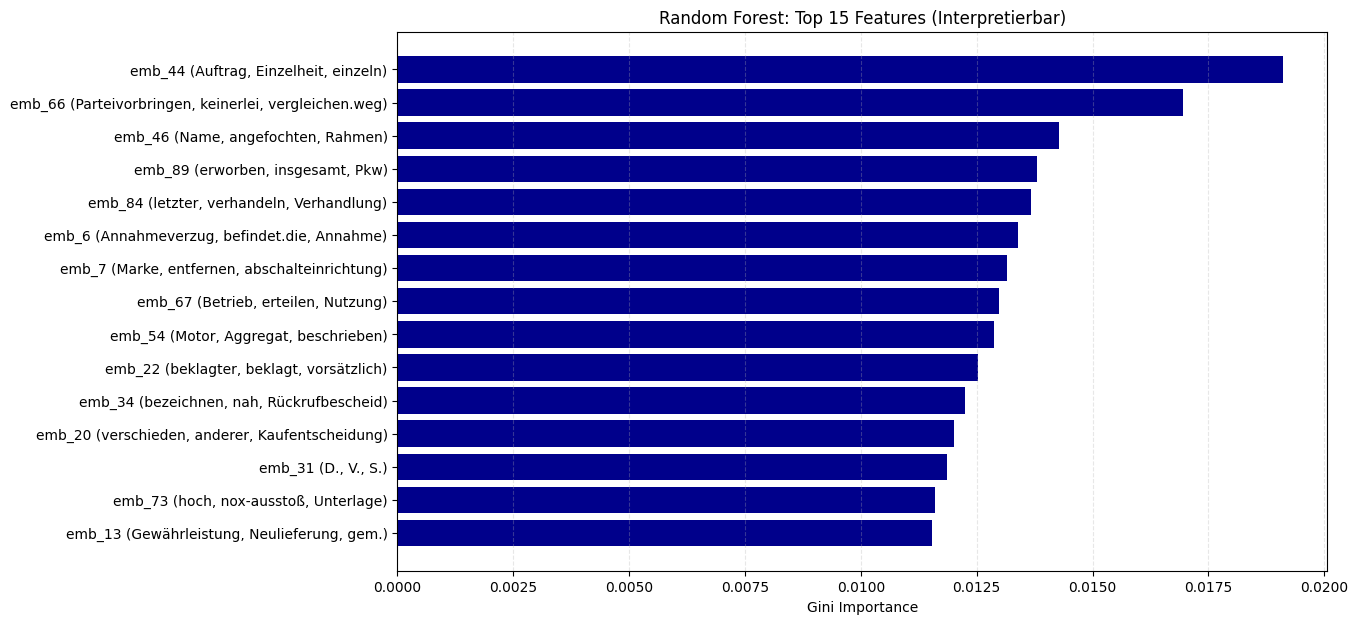

In [25]:
# %% [markdown]
# ### 6.2 Random Forest (Ensemble Learning)
# Wir führen eine 5-fache Stratified Cross-Validation durch.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# 1. Sicherstellen, dass das CV-Objekt existiert
# Wir definieren k=5 hier noch einmal lokal zur Sicherheit
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Modell-Initialisierung
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced")

# 3. Cross-Validation (k=5)
scoring = ['accuracy', 'precision', 'recall', 'f1']
print("🚀 Starte Cross-Validation für Random Forest...")

# Wir nutzen cv_local statt cv, um den NameError zu vermeiden
cv_results_rf = cross_validate(rf_model, X_train_final, y_train, cv=cv_local, scoring=scoring)

# 4. Detaillierte Ausgabe der Folds
print("="*40)
print("ERGEBNISSE RANDOM FOREST: CROSS-VALIDATION")
print("="*40)
for i in range(5):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy:  {cv_results_rf['test_accuracy'][i]:.4f}")
    print(f"  - Precision: {cv_results_rf['test_precision'][i]:.4f}")
    print(f"  - Recall:    {cv_results_rf['test_recall'][i]:.4f}")
    print("-" * 20)

print(f"\nMITTELWERTE ÜBER ALLE FOLDS:")
print(f"Mean Accuracy:  {cv_results_rf['test_accuracy'].mean():.4f} (+/- {cv_results_rf['test_accuracy'].std():.4f})")
print(f"Mean Precision: {cv_results_rf['test_precision'].mean():.4f}")
print(f"Mean Recall:    {cv_results_rf['test_recall'].mean():.4f}")

# 5. Finales Training & Feature Importance
rf_model.fit(X_train_final, y_train)

# Visualisierung mit Wort-Mapping (Nutzt die Funktion aus 6.0)
importances = rf_model.feature_importances_
feat_names = X_train_final.columns
top_indices = np.argsort(importances)[-15:]
top_importances = importances[top_indices]
top_names = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices]

plt.figure(figsize=(12, 7))
plt.barh(top_names, top_importances, color='darkblue')
plt.title("Random Forest: Top 15 Features (Interpretierbar)")
plt.xlabel("Gini Importance")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

### Gradient Boosting

In [26]:
# %% [markdown]
# ### 6.3 Gradient Boosting (Boosting)
# Evaluation der Modellstabilität mittels detaillierter CV-Statistiken.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

# 1. Sicherstellen, dass das CV-Objekt existiert
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Modell-Initialisierung
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# 3. Cross-Validation
scoring = ['accuracy', 'precision', 'recall', 'f1']
print("🚀 Starte Cross-Validation für Gradient Boosting...")
cv_results_gb = cross_validate(gb_model, X_train_final, y_train, cv=cv_local, scoring=scoring)

# 4. Detaillierte Ausgabe
print("="*40)
print("ERGEBNISSE GRADIENT BOOSTING: CROSS-VALIDATION")
print("="*40)
for i in range(5):
    print(f"Fold {i+1}: Accuracy {cv_results_gb['test_accuracy'][i]:.4f} | Recall {cv_results_gb['test_recall'][i]:.4f}")

print(f"\nMITTELWERTE:")
print(f"Mean Accuracy:  {cv_results_gb['test_accuracy'].mean():.4f}")
print(f"Mean F1-Score:  {cv_results_gb['test_f1'].mean():.4f}")

# 5. Finales Training & Evaluation auf Test-Set
gb_model.fit(X_train_final, y_train)
y_pred_gb = gb_model.predict(X_test_final)

print("\n" + "#"*40)
print("FINALER TESTSET-BERICHT (GRADIENT BOOSTING)")
print("#"*40)
print(classification_report(y_test, y_pred_gb))

🚀 Starte Cross-Validation für Gradient Boosting...
ERGEBNISSE GRADIENT BOOSTING: CROSS-VALIDATION
Fold 1: Accuracy 0.7429 | Recall 0.6905
Fold 2: Accuracy 0.7371 | Recall 0.7262
Fold 3: Accuracy 0.7644 | Recall 0.7262
Fold 4: Accuracy 0.6954 | Recall 0.6786
Fold 5: Accuracy 0.7644 | Recall 0.7976

MITTELWERTE:
Mean Accuracy:  0.7408
Mean F1-Score:  0.7287

########################################
FINALER TESTSET-BERICHT (GRADIENT BOOSTING)
########################################
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       114
           1       0.71      0.75      0.73       106

    accuracy                           0.73       220
   macro avg       0.73      0.73      0.73       220
weighted avg       0.73      0.73      0.73       220



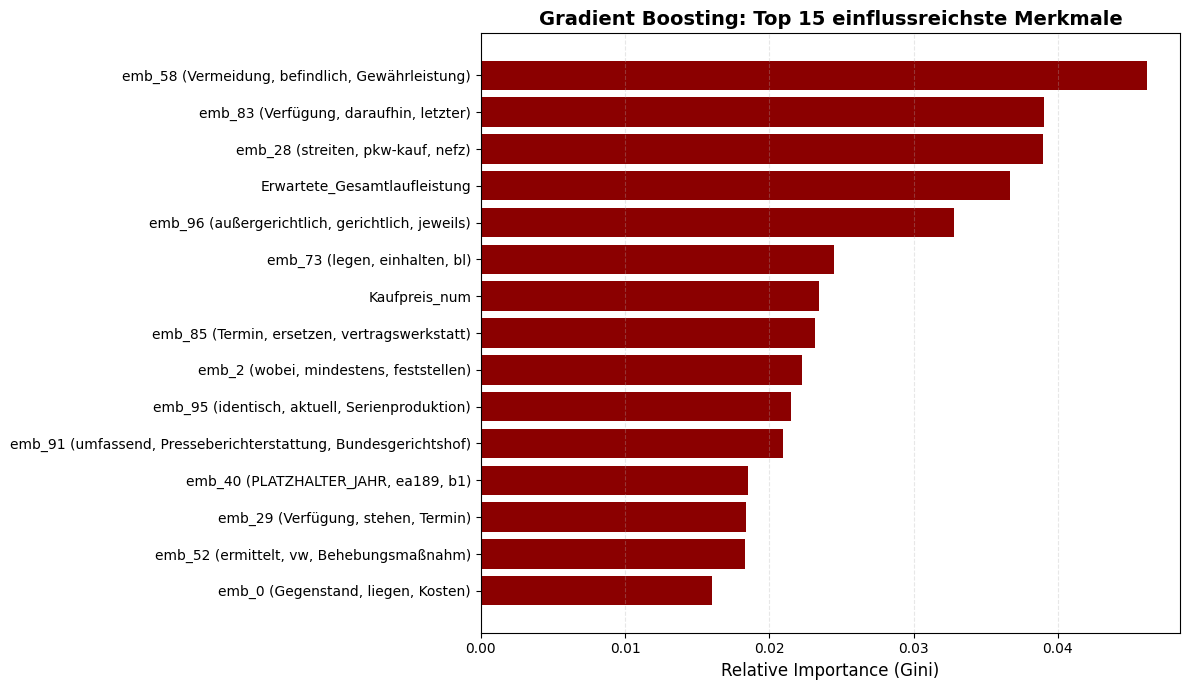

In [46]:
# Visualisierung

import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Importance aus dem Gradient Boosting Modell extrahieren
importances_gb = gb_model.feature_importances_
feat_names = X_train_final.columns

# 2. Top 15 Merkmale identifizieren
top_indices_gb = np.argsort(importances_gb)[-15:]
top_importances_gb = importances_gb[top_indices_gb]

# 3. Namen mappen: Wir nutzen die Funktion aus 6.0, um die Embeddings zu "übersetzen"
top_names_gb = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices_gb]

# 4. Visualisierung
plt.figure(figsize=(12, 7))
plt.barh(top_names_gb, top_importances_gb, color='darkred')

# Styling-Elemente
plt.title("Gradient Boosting: Top 15 einflussreichste Merkmale", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (Gini)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Damit die langen Namen der Wort-Mappigs nicht abgeschnitten werden:
plt.tight_layout()

# Grafik anzeigen
plt.show()

evtl. SHAP Werte für Erklärbarkeit

Test/Test